In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import folium
import datetime
import numpy as np
import pandas as pd
import re
from pytz import timezone
import pytz

In [2]:
def decode_lat_lon(sr: pd.Series) -> pd.Series:
    """
    緯度経度を度数に変換
    dddmm.mmmm
    """
    tmp = sr.astype(float)
    return (tmp / 100).astype(int) + (tmp % 100) / 60

In [3]:
LOG = "matsumoto-nagano-100318.log"
# LOG = "nagano-matsumoto-100318.log"

gps_table = []

gpgga_list = [None] * 13
gprmc_list = [None] * 9

with open(LOG) as f:
    for line in f:
        str_list = line.split(",")
        if str_list[0] == "$GPGGA":
            gpgga_list = str_list[1:-1]
        elif str_list[0] == "$GPRMC":
            gprmc_list = str_list[1:-3]
            if gpgga_list[0] != gprmc_list[0]:
                print(gpgga_list, gprmc_list)
                gpgga_list = [None] * 13
            elif gpgga_list[1:5] != gprmc_list[2:6]:
                print(gpgga_list, gprmc_list)
                gpgga_list = [None] * 13
            gps_table.append(gprmc_list + gpgga_list[5:])
gps_df = pd.DataFrame(gps_table, columns=[
    "time", "status", "lat", "NS", "lon", "EW",
    "knots", "direction", "date", "quality", "sat",
    "harr", "elevation", "em", "geoid", "gm", "drp_id"
])
gps_df

,time,status,lat,NS,lon,EW,knots,direction,date,quality,sat,harr,elevation,em,geoid,gm,drp_id
0,061959,A,3614.2227,N,13759.6135,E,021.3,276.9,180310,1,04,02.2,00613.6,M,037.4,M,00
1,062009,A,3614.2298,N,13759.5359,E,021.8,276.3,180310,1,04,02.2,00614.3,M,037.4,M,00
2,062028,A,3614.2575,N,13759.4495,E,000.3,254.1,180310,1,04,02.2,00609.0,M,037.4,M,00
3,062043,A,3614.2540,N,13759.4548,E,000.8,102.0,180310,1,04,02.2,00604.8,M,037.4,M,00
4,062058,A,3614.2429,N,13759.4589,E,006.5,270.7,180310,1,04,02.2,00579.1,M,037.4,M,00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,074053,A,3632.8942,N,13807.8498,E,005.8,074.3,180310,1,07,01.4,00384.2,M,037.4,M,00
291,074108,A,3632.9447,N,13807.9225,E,022.4,060.2,180310,1,09,01.2,00383.0,M,037.4,M,00
292,074123,A,3632.9938,N,13808.0422,E,026.8,054.8,180310,1,08,01.2,00382.9,M,037.4,M,00
293,074138,A,3633.0934,N,13808.1286,E,031.2,030.5,180310,1,08,01.7,00381.0,M,037.4,M,00


In [4]:
gps_df["lat_deg"] = decode_lat_lon(gps_df["lat"])
gps_df["lon_deg"] = decode_lat_lon(gps_df["lon"])
gps_df["lat"] = gps_df["lat"] * ((gps_df.pop("NS") == "N") * 2 - 1)
gps_df["lon"] = gps_df["lon"] * ((gps_df.pop("EW") == "E") * 2 - 1)

gps_df["lat"] = np.deg2rad(gps_df["lat_deg"])
gps_df["lon"] = np.deg2rad(gps_df["lon_deg"])

gps_df["quality"] = gps_df["quality"].astype(pd.Int64Dtype())
gps_df["sat"] = gps_df["sat"].astype(pd.Int64Dtype())
gps_df["drp_id"] = gps_df["drp_id"].astype(pd.Int64Dtype())
gps_df["knots"] = gps_df["knots"].astype(float)
gps_df["direction"] = gps_df["direction"].astype(float)
gps_df["harr"] = gps_df["harr"].astype(float)
gps_df["elevation"] = gps_df["elevation"].astype(float)
gps_df["geoid"] = gps_df["geoid"].astype(float)
gps_df["date"] = (gps_df["date"] + gps_df["time"]).apply(lambda x: pytz.timezone("UTC").localize(
    datetime.datetime.strptime(x, "%d%m%y%H%M%S")).astimezone(timezone("Asia/Tokyo")))

gps_df = gps_df.drop(["em", "gm", "time"], axis=1)

gps_df

,status,lat,lon,knots,direction,date,quality,sat,harr,elevation,geoid,drp_id,lat_deg,lon_deg
0,A,0.632456,2.408442,21.3,276.9,2010-03-18 15:19:59+09:00,1,4,2.2,613.6,37.4,0,36.237045,137.993558
1,A,0.632458,2.408419,21.8,276.3,2010-03-18 15:20:09+09:00,1,4,2.2,614.3,37.4,0,36.237163,137.992265
2,A,0.632466,2.408394,0.3,254.1,2010-03-18 15:20:28+09:00,1,4,2.2,609.0,37.4,0,36.237625,137.990825
3,A,0.632465,2.408396,0.8,102.0,2010-03-18 15:20:43+09:00,1,4,2.2,604.8,37.4,0,36.237567,137.990913
4,A,0.632462,2.408397,6.5,270.7,2010-03-18 15:20:58+09:00,1,4,2.2,579.1,37.4,0,36.237382,137.990982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,A,0.637887,2.410838,5.8,74.3,2010-03-18 16:40:53+09:00,1,7,1.4,384.2,37.4,0,36.548237,138.130830
291,A,0.637902,2.410859,22.4,60.2,2010-03-18 16:41:08+09:00,1,9,1.2,383.0,37.4,0,36.549078,138.132042
292,A,0.637916,2.410894,26.8,54.8,2010-03-18 16:41:23+09:00,1,8,1.2,382.9,37.4,0,36.549897,138.134037
293,A,0.637945,2.410919,31.2,30.5,2010-03-18 16:41:38+09:00,1,8,1.7,381.0,37.4,0,36.551557,138.135477


In [5]:
fig = folium.Figure()

center_lat = 36.45
center_lon = 138.0

m = folium.Map([center_lat, center_lon], zoom_start=10).add_to(fig)
for i in gps_df.index:
    folium.Marker(location=[gps_df["lat_deg"][i], gps_df["lon_deg"][i]]).add_to(m)
m

In [6]:
use_columns = ["lat", "lon", "knots", "date", "elevation", "geoid"]

lat_lon_df = gps_df[use_columns][1:].copy() # 先頭削除
lat_lon_df_prev = gps_df[use_columns][:-1].copy() # 末尾削除

for uc in use_columns:
    lat_lon_df[uc + "_prev"] = list(lat_lon_df_prev[uc])
    
lat_lon_df

,lat,lon,knots,date,elevation,geoid,lat_prev,lon_prev,knots_prev,date_prev,elevation_prev,geoid_prev
1,0.632458,2.408419,21.8,2010-03-18 15:20:09+09:00,614.3,37.4,0.632456,2.408442,21.3,2010-03-18 15:19:59+09:00,613.6,37.4
2,0.632466,2.408394,0.3,2010-03-18 15:20:28+09:00,609.0,37.4,0.632458,2.408419,21.8,2010-03-18 15:20:09+09:00,614.3,37.4
3,0.632465,2.408396,0.8,2010-03-18 15:20:43+09:00,604.8,37.4,0.632466,2.408394,0.3,2010-03-18 15:20:28+09:00,609.0,37.4
4,0.632462,2.408397,6.5,2010-03-18 15:20:58+09:00,579.1,37.4,0.632465,2.408396,0.8,2010-03-18 15:20:43+09:00,604.8,37.4
5,0.632457,2.408373,20.8,2010-03-18 15:21:13+09:00,580.2,37.4,0.632462,2.408397,6.5,2010-03-18 15:20:58+09:00,579.1,37.4
...,...,...,...,...,...,...,...,...,...,...,...,...
290,0.637887,2.410838,5.8,2010-03-18 16:40:53+09:00,384.2,37.4,0.637887,2.410837,0.9,2010-03-18 16:40:38+09:00,383.0,37.4
291,0.637902,2.410859,22.4,2010-03-18 16:41:08+09:00,383.0,37.4,0.637887,2.410838,5.8,2010-03-18 16:40:53+09:00,384.2,37.4
292,0.637916,2.410894,26.8,2010-03-18 16:41:23+09:00,382.9,37.4,0.637902,2.410859,22.4,2010-03-18 16:41:08+09:00,383.0,37.4
293,0.637945,2.410919,31.2,2010-03-18 16:41:38+09:00,381.0,37.4,0.637916,2.410894,26.8,2010-03-18 16:41:23+09:00,382.9,37.4


### [国土地理院の計算方法](https://vldb.gsi.go.jp/sokuchi/surveycalc/surveycalc/algorithm/bl2st/bl2st.htm)

In [7]:
def calc_dist_kokudo(phi1, L1, phi2, L2):
    """
    引数は (緯度1, 経度1, 緯度2, 経度2)
    いずれも弧度法であること前提
    """
    # GRS80楕円体
    a = 6378.137 # 長半径 (km)
    f = 1 / 298.257222101 # 扁平率

    exception_zones = ("2", "3a", "3b1")

    l = L2 - L1
    if l > np.pi:
        l_prime = l - 2 * np.pi
    elif l < -np.pi:
        l_prime = l + 2 * np.pi
    else:
        l_prime = l
    L = abs(l_prime)
    L_prime = np.pi - L
    if l_prime >= 0:
        u1 = np.arctan((1 - f) * np.tan(phi1))
        u2 = np.arctan((1 - f) * np.tan(phi2))
        delta = phi2 - phi1
    else:
        u1 = np.arctan((1 - f) * np.tan(phi2))
        u2 = np.arctan((1 - f) * np.tan(phi1))
        delta = phi1 - phi2
    SIGMA = phi1 + phi2
    SIGMA_prime = u1 + u2
    delta_prime = u2 - u1
    xi = np.cos(SIGMA_prime / 2)
    xi_prime = np.sin(SIGMA_prime / 2)
    eta = np.sin(delta_prime / 2)
    eta_prime = np.cos(delta_prime / 2)
    
    x = np.sin(u1) * np.sin(u2)
    y = np.cos(u1) * np.cos(u2)
    c = y * np.cos(L) + x
    epsilon = f * (2 - f) / (1 - f) ** 2
    
    if c >= 0:
        theta = L * (1 + f * y)
        zone = "1"
        
    if zone != "1":
        print("未実装")
        return -1
    F = 1
    while abs(F) >= 1e-15:
        if zone in exception_zones:
            g = np.sqrt((eta * np.sin(theta / 2)) ** 2 + (xi * np.cos(theta / 2)) ** 2)
            h = np.sqrt((eta_prime * np.sin(theta / 2)) ** 2 + (xi_prime * np.cos(theta / 2)) ** 2)
        else:
            g = np.sqrt((eta * np.cos(theta / 2)) ** 2 + (xi * np.sin(theta / 2)) ** 2)
            h = np.sqrt((eta_prime * np.cos(theta / 2)) ** 2 + (xi_prime * np.sin(theta / 2)) ** 2)
        
        sigma = 2 * np.arctan(g / h)
        J = 2 * g * h
        K = h ** 2 - g ** 2
        gamma = y * np.sin(theta) / J
        GAMMA = 1 - gamma ** 2
        zeta = GAMMA * K - 2 * x
        zeta_prime = zeta + x
        D = f * (1 + f) / 4 - 3 * f ** 2 * GAMMA / 16
        E = (1 - D * GAMMA) * f * gamma * (sigma + D * J * (zeta + D * K * (2 * zeta ** 2 - GAMMA ** 2)))
        if zone in exception_zones:
            F = theta - L_prime + E
        else:
            F = theta - L - E
        G = f * gamma ** 2 * (1 - 2 * D * GAMMA) + f * zeta_prime * (sigma / J) * (1 - D * GAMMA + f * gamma ** 2 / 2)\
            + f ** 2 * zeta * zeta_prime / 4
        theta = theta - F / (1 - G)
#         print(F, theta)
    
    n0 = epsilon * GAMMA / (np.sqrt(1 + epsilon * GAMMA) + 1) ** 2
    A = (1 + n0) * (1 + 5 * n0 ** 2 / 4)
    B = epsilon * (1 - 3 * n0 ** 2 / 8) / (np.sqrt(1 + epsilon * GAMMA) + 1) ** 2
    s = (1 - f) * a * A * (sigma - B * J * (zeta - B * (K * (GAMMA ** 2 - 2 * zeta ** 2)\
        - B * zeta * (1 - 4 * K ** 2) * (3 * GAMMA ** 2 - 4 * zeta ** 2) / 6) / 4))
    return s

### [ヒュベニの公式](https://www.trail-note.net/tech/calc_distance/)

In [8]:
def calc_dist_hubeny(lat1, lon1, lat2, lon2):
    Rx = 6378.137 # 長半径 (km)
    Ry = 6356.752314245 # 短半径(km)
    E = np.sqrt((Rx ** 2 - Ry ** 2) / Rx ** 2) # 第一離心率
    
    P = (lat1 + lat2) / 2
    W = np.sqrt(1 - E ** 2 * np.sin(P) ** 2)
    M = Rx * (1 - E ** 2) / (W ** 3) # 子午線曲率半径
    N = Rx / W # 卯酉線曲率半径
    Dy = lat2 - lat1
    Dx = lon2 - lon1
    return np.sqrt((Dy * M) ** 2 + (Dx * N * np.cos(P)) ** 2)

### 球の接平面近似

In [9]:
def calc_dist_tangent(lat1, lon1, lat2, lon2):
    # 地球の長半径 (km)
    # r = 6378.137
    # 地球の極半径
    r = 6356.752

    # 緯度の最大値 (距離は最小値)
    example_lat = gps_df["lat"].max()
    # example_lat = gps_df["lat"].mean()

    return r * np.sqrt((lat1 - lat2) ** 2 + ((lon1 - lon2) * np.cos(example_lat)) ** 2)
# print(f"地球の半径: {R}, 緯度の代表値: {example_lat:.4f}")

### 球面近似と楕円体高

In [10]:
# 地球の長半径 (km)
R = 6378.137
# 地球の極半径
# R = 6356.752

# 簡単化のため欠損値除去
df2 = gps_df.dropna()

# 各点の半径
local_R = (df2["elevation"] + df2["geoid"]) / 1000 + R

x = np.cos(df2["lat"]) * np.cos(df2["lon"]) * local_R
y = np.cos(df2["lat"]) * np.sin(df2["lon"]) * local_R
z = np.sin(df2["lat"]) * local_R

df_3d = pd.DataFrame({"x": x, "y": y, "z": z})

use_columns = list(df_3d.columns)

df_3d_mem = df_3d[use_columns][1:].copy() # 先頭削除
df_3d_prev = df_3d[use_columns][:-1].copy() # 末尾削除

for uc in use_columns:
    df_3d_mem[uc + "_prev"] = list(df_3d_prev[uc])

df_3d_mem["dist_3d"] = np.sqrt(
    (df_3d_mem["x"] - df_3d_mem["x_prev"]) ** 2 + 
    (df_3d_mem["y"] - df_3d_mem["y_prev"]) ** 2 + 
    (df_3d_mem["z"] - df_3d_mem["z_prev"]) ** 2
)

df_3d_mem

,x,y,z,x_prev,y_prev,z_prev,dist_3d
1,-3823.003921,3443.182840,3770.686705,-3823.087010,3443.101377,3770.675665,0.116884
2,-3822.891631,3443.255727,3770.725028,-3823.003921,3443.182840,3770.686705,0.139249
3,-3822.897275,3443.250136,3770.717307,-3822.891631,3443.255727,3770.725028,0.011078
4,-3822.895026,3443.239852,3770.685502,-3822.897275,3443.250136,3770.717307,0.033501
5,-3822.824019,3443.345087,3770.663255,-3822.895026,3443.239852,3770.685502,0.128885
...,...,...,...,...,...,...,...
290,-3815.880822,3420.089572,3798.427397,-3815.876172,3420.093811,3798.426235,0.006399
291,-3815.910877,3419.970990,3798.501957,-3815.880822,3420.089572,3798.427397,0.143262
292,-3815.989493,3419.801859,3798.575084,-3815.910877,3419.970990,3798.501957,0.200333
293,-3815.992342,3419.631484,3798.722409,-3815.989493,3419.801859,3798.575084,0.225256


### 区分求積法

In [11]:
# 地球の長半径 (km)
R = 6378.137

lat_lon_df["lat_mean"] = (lat_lon_df["lat"] + lat_lon_df["lat_prev"]) / 2.0
delta_lat = lat_lon_df["lat"] - lat_lon_df["lat_prev"]
delta_lon = lat_lon_df["lon"] - lat_lon_df["lon_prev"]

d = np.sqrt(delta_lat ** 2 + (delta_lon * np.cos(lat_lon_df["lat_mean"])) ** 2)
delta_seconds = (lat_lon_df["date"] - lat_lon_df["date_prev"]).apply(lambda x: x.total_seconds())

# 平均移動速度からknotsを計算
lat_lon_df["average_knots"] = d / np.pi / delta_seconds * 3.888e7

lat_lon_df["dist_quad"] = lat_lon_df["knots"] * np.pi * delta_seconds * R / 3.888e7
print(lat_lon_df["dist_quad"].sum())
lat_lon_df

57.19327445591671


,lat,lon,knots,date,elevation,geoid,lat_prev,lon_prev,knots_prev,date_prev,elevation_prev,geoid_prev,lat_mean,average_knots,dist_quad
1,0.632458,2.408419,21.8,2010-03-18 15:20:09+09:00,614.3,37.4,0.632456,2.408442,21.3,2010-03-18 15:19:59+09:00,613.6,37.4,0.632457,22.677062,0.112350
2,0.632466,2.408394,0.3,2010-03-18 15:20:28+09:00,609.0,37.4,0.632458,2.408419,21.8,2010-03-18 15:20:09+09:00,614.3,37.4,0.632462,14.208903,0.002938
3,0.632465,2.408396,0.8,2010-03-18 15:20:43+09:00,604.8,37.4,0.632466,2.408394,0.3,2010-03-18 15:20:28+09:00,609.0,37.4,0.632465,1.325969,0.006184
4,0.632462,2.408397,6.5,2010-03-18 15:20:58+09:00,579.1,37.4,0.632465,2.408396,0.8,2010-03-18 15:20:43+09:00,604.8,37.4,0.632463,2.779713,0.050248
5,0.632457,2.408373,20.8,2010-03-18 15:21:13+09:00,580.2,37.4,0.632462,2.408397,6.5,2010-03-18 15:20:58+09:00,579.1,37.4,0.632459,16.670029,0.160795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,0.637887,2.410838,5.8,2010-03-18 16:40:53+09:00,384.2,37.4,0.637887,2.410837,0.9,2010-03-18 16:40:38+09:00,383.0,37.4,0.637887,0.812977,0.044837
291,0.637902,2.410859,22.4,2010-03-18 16:41:08+09:00,383.0,37.4,0.637887,2.410838,5.8,2010-03-18 16:40:53+09:00,384.2,37.4,0.637894,18.530170,0.173164
292,0.637916,2.410894,26.8,2010-03-18 16:41:23+09:00,382.9,37.4,0.637902,2.410859,22.4,2010-03-18 16:41:08+09:00,383.0,37.4,0.637909,25.912867,0.207178
293,0.637945,2.410919,31.2,2010-03-18 16:41:38+09:00,381.0,37.4,0.637916,2.410894,26.8,2010-03-18 16:41:23+09:00,382.9,37.4,0.637931,29.135634,0.241192


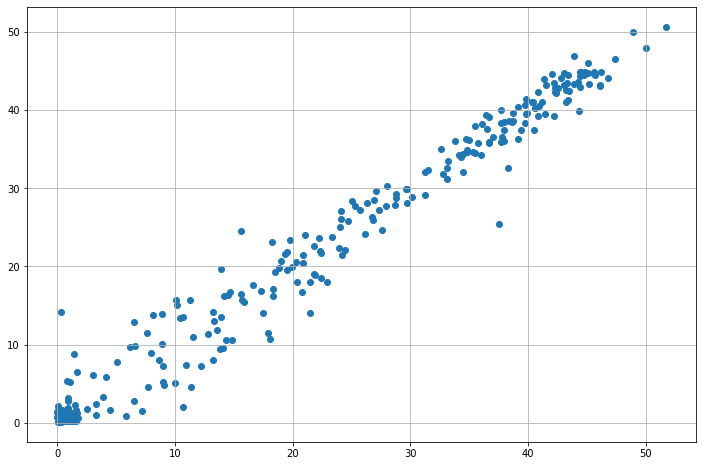

In [12]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.scatter(lat_lon_df["knots"], lat_lon_df["average_knots"])
ax.grid()
plt.show()

In [13]:
dist_list_kokudo = []
dist_list_tangent = []
dist_list_hubeny = []

for idx, sr in lat_lon_df.iterrows():
    dist_list_kokudo.append(calc_dist_kokudo(sr["lat"], sr["lon"], sr["lat_prev"], sr["lon_prev"]))
    dist_list_tangent.append(calc_dist_tangent(sr["lat"], sr["lon"], sr["lat_prev"], sr["lon_prev"]))
    dist_list_hubeny.append(calc_dist_hubeny(sr["lat"], sr["lon"], sr["lat_prev"], sr["lon_prev"]))
    
lat_lon_df["dist_kokudo"] = dist_list_kokudo
lat_lon_df["dist_tangent"] = dist_list_tangent
lat_lon_df["dist_hubeny"] = dist_list_hubeny

lat_lon_df["dist_3d"] = df_3d_mem["dist_3d"]

lat_lon_df

,lat,lon,knots,date,elevation,geoid,lat_prev,lon_prev,knots_prev,date_prev,elevation_prev,geoid_prev,lat_mean,average_knots,dist_quad,dist_kokudo,dist_tangent,dist_hubeny,dist_3d
1,0.632458,2.408419,21.8,2010-03-18 15:20:09+09:00,614.3,37.4,0.632456,2.408442,21.3,2010-03-18 15:19:59+09:00,613.6,37.4,0.632457,22.677062,0.112350,0.117001,0.116004,0.117001,0.116884
2,0.632466,2.408394,0.3,2010-03-18 15:20:28+09:00,609.0,37.4,0.632458,2.408419,21.8,2010-03-18 15:20:09+09:00,614.3,37.4,0.632462,14.208903,0.002938,0.139214,0.138174,0.139214,0.139249
3,0.632465,2.408396,0.8,2010-03-18 15:20:43+09:00,604.8,37.4,0.632466,2.408394,0.3,2010-03-18 15:20:28+09:00,609.0,37.4,0.632465,1.325969,0.006184,0.010244,0.010191,0.010244,0.011078
4,0.632462,2.408397,6.5,2010-03-18 15:20:58+09:00,579.1,37.4,0.632465,2.408396,0.8,2010-03-18 15:20:43+09:00,604.8,37.4,0.632463,2.779713,0.050248,0.021428,0.021409,0.021428,0.033501
5,0.632457,2.408373,20.8,2010-03-18 15:21:13+09:00,580.2,37.4,0.632462,2.408397,6.5,2010-03-18 15:20:58+09:00,579.1,37.4,0.632459,16.670029,0.160795,0.128992,0.127933,0.128992,0.128885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,0.637887,2.410838,5.8,2010-03-18 16:40:53+09:00,384.2,37.4,0.637887,2.410837,0.9,2010-03-18 16:40:38+09:00,383.0,37.4,0.637887,0.812977,0.044837,0.006292,0.006263,0.006292,0.006399
291,0.637902,2.410859,22.4,2010-03-18 16:41:08+09:00,383.0,37.4,0.637887,2.410838,5.8,2010-03-18 16:40:53+09:00,384.2,37.4,0.637894,18.530170,0.173164,0.143153,0.142758,0.143153,0.143262
292,0.637916,2.410894,26.8,2010-03-18 16:41:23+09:00,382.9,37.4,0.637902,2.410859,22.4,2010-03-18 16:41:08+09:00,383.0,37.4,0.637909,25.912867,0.207178,0.200379,0.199631,0.200379,0.200333
293,0.637945,2.410919,31.2,2010-03-18 16:41:38+09:00,381.0,37.4,0.637916,2.410894,26.8,2010-03-18 16:41:23+09:00,382.9,37.4,0.637931,29.135634,0.241192,0.224845,0.224471,0.224845,0.225256


In [14]:
lat_lon_df.filter(regex=r'dist', axis=1).sum()

dist_quad       57.193274
dist_kokudo     56.464758
dist_tangent    56.298911
dist_hubeny     56.464758
dist_3d         56.881811
dtype: float64

### 3次元プロット

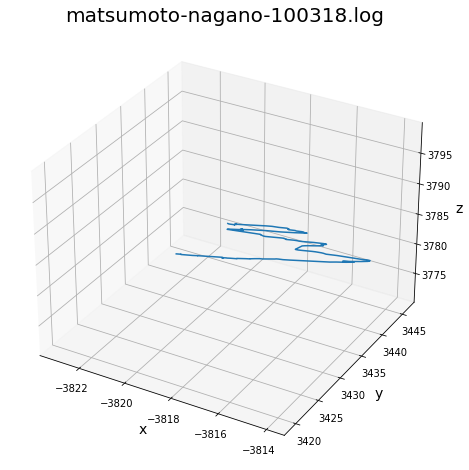

In [15]:
# Figureを追加
fig = plt.figure(figsize = (8, 8))

# 3DAxesを追加
ax = fig.add_subplot(111, projection='3d')
# Axesのタイトルを設定
ax.set_title(LOG, size = 20)

# 軸ラベルを設定
ax.set_xlabel("x", size = 14)
ax.set_ylabel("y", size = 14)
ax.set_zlabel("z", size = 14)

# 曲線を描画
ax.plot(x, y, z)

plt.show()

### できるだけxy平面になるように回転

In [16]:
example_lat = gps_df["lat"].mean()
example_lon = gps_df["lon"].mean()

# 本初子午線あたりに移動
rot_matrix1 = np.matrix([
    [np.cos(example_lon), np.sin(example_lon), 0],
    [-np.sin(example_lon), np.cos(example_lon), 0],
    [0, 0, 1]
])

# 北極あたりに移動
rot_matrix2 = np.matrix([
    [np.sin(example_lat), 0, -np.cos(example_lat)],
    [0, 1, 0],
    [np.cos(example_lat), 0, np.sin(example_lat)]
])

rot_matrix = rot_matrix2 * rot_matrix1
print("回転行列")
print(rot_matrix)

xyz_matrix = np.matrix(df_3d).T
xyz_matrix_rotated = rot_matrix * xyz_matrix
df_3d_rotated = pd.DataFrame(xyz_matrix_rotated.T, columns=["x", "y", "z"])

# 高さを最小値基準とする
df_3d_rotated_mapped = df_3d_rotated.copy()
df_3d_rotated_mapped["z"] -= df_3d_rotated["z"].min()
df_3d_rotated_mapped

回転行列
[[-0.44096926  0.39680268 -0.8050427 ]
 [-0.66889986 -0.74335253  0.        ]
 [-0.59843053  0.53849295  0.59321686]]


,x,y,z
0,16.540743,-2.175760,0.262917
1,16.527541,-2.291894,0.263611
2,16.476095,-2.421186,0.258396
3,16.482581,-2.413254,0.254182
4,16.503112,-2.407114,0.228431
...,...,...,...
290,-18.109440,10.109905,0.021615
291,-18.203263,10.218157,0.019975
292,-18.294578,10.396468,0.019326
293,-18.479530,10.525022,0.016682


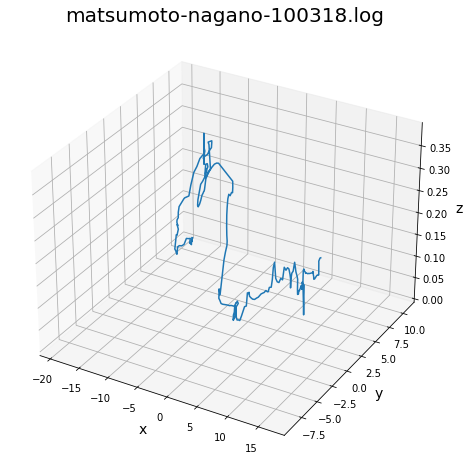

In [17]:
# Figureを追加
fig = plt.figure(figsize = (8, 8))

# 3DAxesを追加
ax = fig.add_subplot(111, projection='3d')
# Axesのタイトルを設定
ax.set_title(LOG, size = 20)

# 軸ラベルを設定
ax.set_xlabel("x", size = 14)
ax.set_ylabel("y", size = 14)
ax.set_zlabel("z", size = 14)

# 曲線を描画
ax.plot(*df_3d_rotated_mapped.values.T.tolist())

plt.show()